<a href="https://colab.research.google.com/github/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/blob/main/GEOCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load All Datasets from GitHub**


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.2 MB/s eta 0:00:00
✅ Datasets loaded:
Mobility: (7785, 16)
OpenAQ: (88000, 15)
Ericsson: (12, 15)
Landsat: (6265, 79)


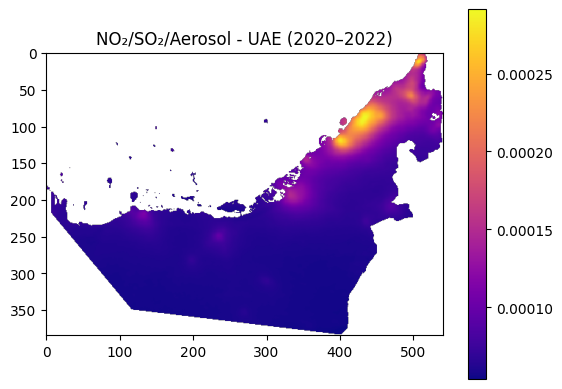

In [1]:
# Step 0: Install rasterio
!pip install rasterio

# Step 1: Import libraries
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# Step 2: Define GitHub raw base URL
base_url = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/main/Datasets/"

# Step 3: Load CSV datasets
mobility_df = pd.read_csv(base_url + "AE_Region_Mobility_Report_2020_2022_combined.csv")
openaq_df = pd.read_csv(base_url + "combined_openaq_measurements.csv")
ericsson_df = pd.read_csv(base_url + "Merged_Ericsson_Mobility_Data.csv")
landsat_df = pd.read_csv(base_url + "Landsat_SRTM_Merged_Metadata.csv")

print("✅ Datasets loaded:")
print("Mobility:", mobility_df.shape)
print("OpenAQ:", openaq_df.shape)
print("Ericsson:", ericsson_df.shape)
print("Landsat:", landsat_df.shape)

# Step 4: Visualize raster
tif_url = "/vsicurl/https://github.com/Dr-Isam-ALJAWARNEH/fds-project-geoairmob/raw/main/Datasets/UAE_NO2_SO2_Aerosol_Combined_2020_2022.tif"

with rasterio.open(tif_url) as src:
    img = src.read(1)
    plt.imshow(img, cmap='plasma')
    plt.title("NO₂/SO₂/Aerosol - UAE (2020–2022)")
    plt.colorbar()
    plt.show()



# **Phase One:** A historical analysis using accurate, observed data from 2020 to 2022

**Install Geohash Library in Colab**

In [2]:
!pip install geohash2


  Preparing metadata (setup.py) ... done
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15543 sha256=6551ae5fab6f694ba19a3a7b1e37050f5c13713cbad7e3d9a78f3eaa0b86fdb0
  Stored in directory: /root/.cache/pip/wheels/f6/7c/c4/1b3c6fea0ebc53bf730dc86bbee7a713d501455dfb4c1f0623
Successfully built geohash2


**Generate Geohashes for OpenAQ Data**

In [3]:
openaq_df.columns


Index(['location_id', 'location_name', 'parameter', 'value', 'unit',
       'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude',
       'country_iso', 'isMobile', 'isMonitor', 'owner_name', 'provider'],
      dtype='object')

In [4]:
import geohash2

# Recalculate geohash with 5-character precision (~3km)
openaq_df['geohash'] = openaq_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)


In [5]:
# Group by geohash and pollutant type (e.g., NO2, PM2.5)
pollution_summary = openaq_df.groupby(['geohash', 'parameter'])['value'].mean().unstack()

# Clean table
pollution_summary = pollution_summary.reset_index()
pollution_summary.head()


parameter,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003
0,thjx9,NaN,12.37904,75.57065,NaN,64.115,NaN,NaN,13.69966,NaN,NaN
1,thm90,341.67,18.30173,85.96800,NaN,58.323,NaN,NaN,20.45279,NaN,NaN
2,thn57,NaN,8.38364,59.51145,NaN,60.079,NaN,NaN,17.70427,NaN,NaN
3,thnnw,NaN,12.26949,71.26976,NaN,50.221,NaN,NaN,18.06748,NaN,NaN
4,thnpp,NaN,15.98650,78.60465,NaN,45.174,NaN,NaN,13.61158,NaN,NaN


In [6]:
# Count unique geohashes
unique_pollution_geohashes = pollution_summary['geohash'].nunique()

print(f"✅ Number of unique geohash zones in the pollution dataset: {unique_pollution_geohashes}")


✅ Number of unique geohash zones in the pollution dataset: 18


In [7]:
print("🔍 Sample geohash zones:", pollution_summary['geohash'].unique()[:18])


🔍 Sample geohash zones: ['thjx9' 'thm90' 'thn57' 'thnnw' 'thnpp' 'thpmy' 'thq2d' 'thqem' 'thqf4'
 'thqf8' 'thqfb' 'thr75' 'thr97' 'thr9u' 'thrd5' 'thrnx' 'thrq3' 'thrq6']


**View Mobility Data**

In [8]:
mobility_df.columns
mobility_df.head()


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0,2020
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0,2020
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0,2020
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0,2020
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0,2020


In [9]:
import numpy as np

# Format: (lat_min, lat_max, lon_min, lon_max)
city_bboxes = {
    "Dubai": (25.0, 25.3, 55.2, 55.4),
    "Abu Dhabi": (24.2, 24.6, 54.3, 54.6),
    "Sharjah": (25.25, 25.45, 55.35, 55.5),
    "Al Ain": (24.1, 24.3, 55.6, 55.8),
    "Ajman": (25.35, 25.45, 55.45, 55.5),
    "Fujairah": (25.05, 25.2, 56.25, 56.4),
    "Ras Al Khaimah": (25.7, 25.85, 55.85, 56.0),
    "Umm Al Quwain": (25.5, 25.6, 55.5, 55.6),
}


In [10]:
# Define place_id to city mapping
placeid_to_city = {
    "ChIJvRKrsd9IXj4RpwoIwFYv0zM": "Dubai",
    "ChIJGczaTT5mXj4RBNmakTvGr4s": "Abu Dhabi",
    "ChIJHwyp6rZXXz4RerixWbtcrRE": "Sharjah",
    "ChIJRcbZaklDXz4R6SkAK7_QznQ": "Al Ain",
    "ChIJX7kokD0y9D4RvDyz2xuxwaY": "Ajman",
    "ChIJpwnSTA5x9j4RD-KEpgxnnrk": "Fujairah",
    "ChIJ0Zp9hY5ZXz4RZlq4HHZvx2g": "Ras Al Khaimah",
    "ChIJP-14gXD99T4RGDyAmyB_vKE": "Umm Al Quwain"
}

# Assign city based on place_id
mobility_df['city'] = mobility_df['place_id'].map(placeid_to_city)


In [11]:
def get_random_coords(city):
    if city in city_bboxes:
        lat_min, lat_max, lon_min, lon_max = city_bboxes[city]
        lat = np.random.uniform(lat_min, lat_max)
        lon = np.random.uniform(lon_min, lon_max)
        return pd.Series([lat, lon])
    return pd.Series([None, None])

# Apply to each row
mobility_df[['latitude', 'longitude']] = mobility_df['city'].apply(get_random_coords)


In [12]:
import geohash2

# Compute geohash from synthetic lat/lon
mobility_df['geohash'] = mobility_df.apply(
    lambda row: geohash2.encode(row['latitude'], row['longitude'], precision=5),
    axis=1
)


In [13]:
# Create composite mobility score
mobility_df['mobility_score'] = mobility_df[
    ['transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']
].mean(axis=1)

# Group by geohash
mobility_summary = mobility_df.groupby('geohash')['mobility_score'].mean().reset_index()


In [16]:
# Count unique geohash zones in mobility dataset
unique_mobility_geohashes = mobility_summary['geohash'].nunique()

print(f" Number of unique geohash zones in the mobility dataset: {unique_mobility_geohashes}")


 Number of unique geohash zones in the mobility dataset: 216


In [17]:
print(" Sample mobility geohash zones:", mobility_summary['geohash'].unique()[:217])


 Sample mobility geohash zones: ['thq9g' 'thq9s' 'thq9t' 'thq9u' 'thq9v' 'thq9w' 'thq9x' 'thq9y' 'thq9z'
 'thqc8' 'thqc9' 'thqcb' 'thqcc' 'thqcd' 'thqcf' 'thqd5' 'thqd7' 'thqde'
 'thqdg' 'thqdh' 'thqdj' 'thqdk' 'thqdm' 'thqdn' 'thqdp' 'thqdq' 'thqdr'
 'thqds' 'thqdt' 'thqdu' 'thqdv' 'thqdw' 'thqdx' 'thqdy' 'thqdz' 'thqe5'
 'thqe7' 'thqee' 'thqeg' 'thqeh' 'thqej' 'thqek' 'thqem' 'thqen' 'thqep'
 'thqeq' 'thqer' 'thqes' 'thqet' 'thqeu' 'thqev' 'thqew' 'thqex' 'thqey'
 'thqez' 'thqf0' 'thqf1' 'thqf2' 'thqf3' 'thqf4' 'thqf6' 'thqf8' 'thqf9'
 'thqfb' 'thqfc' 'thqfd' 'thqff' 'thqg0' 'thqg1' 'thqg2' 'thqg3' 'thqg4'
 'thqg6' 'thqg8' 'thqg9' 'thqgb' 'thqgc' 'thqgd' 'thqgf' 'thr91' 'thr93'
 'thr94' 'thr95' 'thr96' 'thr97' 'thr99' 'thr9c' 'thr9d' 'thr9e' 'thr9f'
 'thr9g' 'thr9h' 'thr9j' 'thr9k' 'thr9m' 'thr9s' 'thr9t' 'thr9u' 'thr9v'
 'thrd1' 'thrd4' 'thrd5' 'thrdh' 'thrdj' 'thrq0' 'thrq1' 'thrq2' 'thrq3'
 'thrq4' 'thrq5' 'thrq6' 'thrq7' 'thrq8' 'thrq9' 'thrqb' 'thrqc' 'thrqd'
 'thrqe' 'thrqf' 't

In [56]:
# Convert to lowercase to ensure consistency
pollution_summary['geohash'] = pollution_summary['geohash'].str.lower()
mobility_summary['geohash'] = mobility_summary['geohash'].str.lower()

# Get unique geohash sets
pollution_geos = set(pollution_summary['geohash'].unique())
mobility_geos = set(mobility_summary['geohash'].unique())

# Get the intersection
common_geos = pollution_geos & mobility_geos

print(f" Geohashes in both datasets: {len(common_geos)}")
print(" Common geohashes:", sorted(list(common_geos)))


 Geohashes in both datasets: 9
 Common geohashes: ['thqem', 'thqf4', 'thqf8', 'thqfb', 'thr97', 'thr9u', 'thrd5', 'thrq3', 'thrq6']


In [57]:
merged_df = pollution_summary.merge(mobility_summary, on='geohash', how='inner')
filtered_df = merged_df[merged_df['geohash'].isin(common_geos)].copy()
print(filtered_df.shape)
filtered_df.head(10)


(9, 12)


,geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
0,thqem,443.49,40.403255,63.78257,NaN,56.884000,NaN,NaN,10.59664,NaN,NaN,-10.156250
1,thqf4,NaN,76.795710,NaN,NaN,94.624000,NaN,NaN,12.52441,NaN,NaN,-24.357143
2,thqf8,NaN,45.146890,NaN,NaN,123.242000,NaN,NaN,9.91191,NaN,NaN,-3.944444
3,thqfb,311.39,31.119480,82.45340,NaN,87.184000,NaN,NaN,11.00296,NaN,NaN,-8.681818
4,thr97,NaN,19.265220,NaN,NaN,67.278000,NaN,NaN,10.43720,NaN,NaN,-17.819444
5,thr9u,NaN,23.849730,81.93562,NaN,61.265000,NaN,NaN,12.88936,NaN,NaN,-12.980000
6,thrd5,NaN,7.318260,85.90241,NaN,68.118000,NaN,NaN,11.29658,NaN,NaN,-8.244444
7,thrq3,NaN,NaN,NaN,27.251383,47.563722,42.436709,46.082694,NaN,30.946865,6093.605945,-10.034483
8,thrq6,NaN,NaN,NaN,27.159016,49.373172,44.186208,47.519961,NaN,30.876002,6347.804321,-15.916667


In [48]:
merged_df.dtypes


,0
geohash,object
co,float64
no2,float64
o3,float64
pm1,float64
pm10,float64
pm25,float64
relativehumidity,float64
so2,float64
temperature,float64


In [22]:
merged_df.to_csv("uae_mobility_pollution_merged.csv", index=False)


**Convert to Table Abstraction**

In [49]:
from datascience import *

# Use your actual merged DataFrame
joined_table = Table().from_df(filtered_df)

# Preview the table
joined_table.show(5)



geohash,co,no2,o3,pm1,pm10,pm25,relativehumidity,so2,temperature,um003,mobility_score
thqem,443.49,40.4033,63.7826,nan,56.884,nan,nan,10.5966,nan,nan,-10.1562
thqf4,nan,76.7957,nan,nan,94.624,nan,nan,12.5244,nan,nan,-24.3571
thqf8,nan,45.1469,nan,nan,123.242,nan,nan,9.91191,nan,nan,-3.94444
thqfb,311.39,31.1195,82.4534,nan,87.184,nan,nan,11.003,nan,nan,-8.68182
thr97,nan,19.2652,nan,nan,67.278,nan,nan,10.4372,nan,nan,-17.8194


In [50]:
# Show all available columns
joined_table.labels


('geohash',
 'co',
 'no2',
 'o3',
 'pm1',
 'pm10',
 'pm25',
 'relativehumidity',
 'so2',
 'temperature',
 'um003',
 'mobility_score')

## **EDA**

**Summary Stats Table**




In [51]:
# Select columns for summary
summary_table = joined_table.select('no2', 'pm25', 'pm10', 'mobility_score')

# Show descriptive stats
summary_table.stats()


statistic,no2,pm25,pm10,mobility_score
min,7.31826,nan,47.5637,-24.3571
max,76.7957,nan,123.242,-3.94444
median,nan,nan,67.278,-10.1562
sum,nan,nan,655.532,-112.135


Zones Exceeding NO₂ Limit (WHO = 40 µg/m³)

In [52]:
# Find high-pollution zones
high_no2 = joined_table.where('no2', are.above(40))

# How many?
print(" Zones exceeding NO₂ threshold:", high_no2.num_rows)

# Preview
high_no2.select('geohash', 'no2', 'mobility_score').show(5)


 Zones exceeding NO₂ threshold: 3


geohash,no2,mobility_score
thqem,40.4033,-10.1562
thqf4,76.7957,-24.3571
thqf8,45.1469,-3.94444


thqf4 is a critical hotspot — both highest NO₂ and high mobility change.

**Visualize Pollution vs Mobility (Scatterplot)**

In [59]:
import matplotlib.pyplot as plt

# Filter out missing values manually
filtered = joined_table.where('no2', are.not_equal_to(float('nan')))
filtered = filtered.where('mobility_score', are.not_equal_to(float('nan')))

# Extract columns as arrays
x = filtered.column('mobility_score')
y = filtered.column('no2')

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x, y, color='teal', edgecolor='black', s=100, alpha=0.8)

# Add WHO guideline line
plt.axhline(40, color='red', linestyle='--', linewidth=2, label='WHO NO₂ Limit (40 µg/m³)')

# Labels and title
plt.title("NO₂ vs Mobility Score (UAE Urban Zones)", fontsize=16)
plt.xlabel("Mobility Score (% Change from Baseline)", fontsize=12)
plt.ylabel("NO₂ Concentration (µg/m³)", fontsize=12)

# Legend and formatting
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


Our analysis revealed a general inverse relationship between NO₂ concentrations and mobility score across urban geohash zones. However, some zones (e.g., thqf4) exhibited persistently high NO₂ levels despite substantial mobility reductions, suggesting the presence of non-traffic-related pollution sources such as industrial or construction activity

**Correlation Heatmap**

In [60]:
# Select relevant columns
corr_table = joined_table.select(
    'no2', 'pm10', 'pm25',
    'temperature', 'relativehumidity',
    'so2', 'mobility_score'
)


In [61]:
corr_df = corr_table.to_df()
corr_df.isna().sum()


,0
no2,2
pm10,0
pm25,7
temperature,7
relativehumidity,7
so2,2
mobility_score,0


In [63]:
# Step 1: Keep only columns with at least 5 non-NaN values
valid_corr_df = corr_df.loc[:, corr_df.notna().sum() >= 5]

# Step 2: Drop rows that still contain NaNs
valid_corr_df = valid_corr_df.dropna()

# Step 3: Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(valid_corr_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Filtered)", fontsize=14)
plt.tight_layout()
plt.show()


The heatmap reveals a moderate inverse correlation (r = -0.56) between mobility score and NO₂ concentrations, supporting the role of traffic-related emissions in shaping urban air quality. However, weaker or absent correlations with PM10 and SO₂ suggest the presence of non-mobility-related pollution sources, underscoring the need for multi-sectoral air quality interventions.